# Quasi-Geostrophic Equations

In [8]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
from jaxsw._src.models.qg import qg_r as qg

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


This is a very simplified equation but

$$
\begin{aligned}
\partial_t q &= - \det\boldsymbol{J}(\psi,q) - \beta\partial_x\psi \\
\psi &= \frac{g}{f_0}\eta \\
q &= \nabla^2 \psi - \frac{f_0^2}{c_1^2}\psi \\
\psi &= \frac{f_0}{g}\eta \\
u &= -\partial_y\psi \\
v &= \partial_x\psi \\
f &= 2\Omega\sin\theta_0 + \frac{1}{R}2\Omega\cos\theta_0 y \\
f_0 &= \mathcal{E}[f] \\
L_R &= \frac{c_1}{f_0}
\end{aligned}
$$

where:
* $\theta_0$ is the mean latitude
* $f_0=2\Omega\sin\theta_0$ is the Coriolis parameter at mean latitude
* $\beta=\frac{1}{R}2\Omega\cos\theta_0$ is the $\beta$-plane approximation at mean latitude
* $L_R$ is the Rossby deformation radius
* $\Omega$ is the angular frequency of rotation
* $R$ is the radius of the Earth

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Read input SSH

In [9]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))
ds = xr.open_dataset("/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.decoded.nc")

# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

## Saved Data

In [27]:
saved_ds = xr.open_dataset("/Users/eman/code_projects/data/scratch/qg_save.nc")
saved_ds

<xarray.Dataset>
Dimensions:  (time: 81, lat: 201, lon: 201)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T06:00:00 ... 2012-10-21
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
Data variables:
    ssh      (time, lat, lon) float32 ...
    pvort    (time, lat, lon) float32 ...

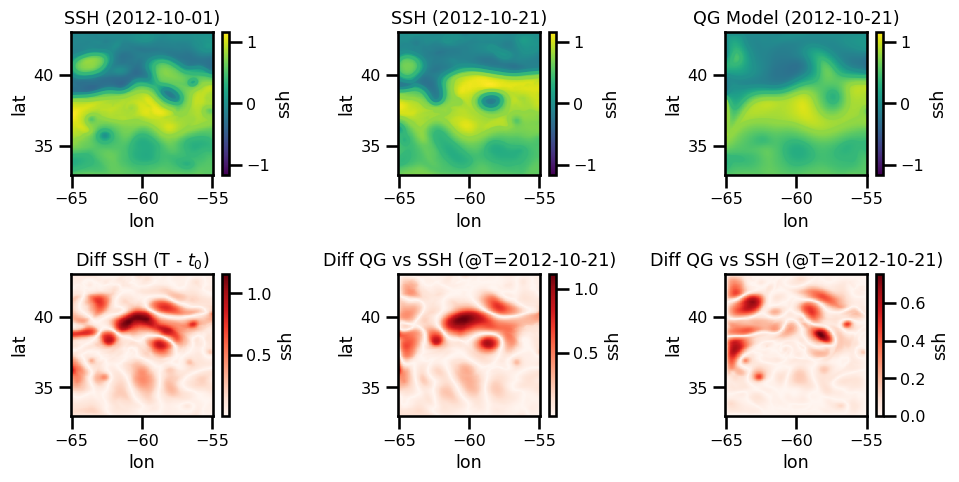

In [28]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))

t0 = "2012-10-01"
t1 = "2012-10-21"

ssh_t0 = ds.ssh.sel(time=t0)
ssh_t1 = ds.ssh.sel(time=t1)
ssh_qg_t1 = saved_ds.ssh.sel(time=t1).mean(dim="time")

# SSH t0
ssh_t0.plot.pcolormesh(ax=ax[0,0], cmap="viridis")
ssh_t0.plot.contour(ax=ax[0,0], cmap="viridis")
ax[0,0].set(title=f"SSH ({t0})")


# SSH t1
ssh_t1.plot.contour(ax=ax[0,1], cmap="viridis")
ssh_t1.plot.pcolormesh(ax=ax[0,1], cmap="viridis")
ax[0,1].set(title=f"SSH ({t1})")


# QG t1
ssh_qg_t1.plot.pcolormesh(ax=ax[0,2], cmap="viridis")
ssh_qg_t1.plot.contour(ax=ax[0,2], cmap="viridis")
ax[0,2].set(title=f"QG Model ({t1})")



np.abs(ssh_t0 - ssh_t1).plot.pcolormesh(ax=ax[1,0], cmap="Reds")
ax[1,0].set(title=f"Diff SSH (T - $t_0$)")


np.abs(ssh_t1 - ssh_qg_t1).plot.pcolormesh(ax=ax[1,1], cmap="Reds")
ax[1,1].set(title=f"Diff QG vs SSH (@T={t1})")

np.abs(ssh_t0 - ssh_qg_t1).plot.pcolormesh(ax=ax[1,2], cmap="Reds")
ax[1,2].set(title=f"Diff QG vs SSH (@T={t1})")


plt.tight_layout()
plt.show()

In [26]:
saved_ds.close()

In [14]:
# 60 secs 60 mins 60 

216000